In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [16]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
# augemtation layer를 만들어 주는 함수
# rotation_factor : rotation 비율
# contrast_factor : contrast 비율 ( 색 대비 )
# seed : 랜덤 시드
# 훈련시에만 활성화 되고 모델 평가에는 활성화 되지 않음
# 모델 summary를 하려면 input을 지정해 주어야 함
# 필요 module
# import tensorflow as tf
# from tensorflow import keras
def make_aug_layer(rotation_factor=0.2, contrast_factor=0.4, seed=42):
    augmentation_layer = keras.models.Sequential([
        keras.layers.RandomFlip('horizontal_and_vertical', seed=seed),
        keras.layers.RandomRotation(factor=rotation_factor, seed=seed),
        keras.layers.RandomContrast(factor=contrast_factor, seed=seed)
    ])
    return augmentation_layer


# 이미지 데이터를 resize 하고 scaling 하는 함수
# dataset을 만들때 map에 사용
# 이미지가 w * h * channel인 형태 기대
# image_size : 변경할 이미지 크기. 튜플로 받음
# scaling_factor : scaling 시 나누어 줄 값. 이미지의 max 값을 넣음
# 필요 module
# import tensorflow as tf
# from tensorflow import keras
def resize_and_scaling(x, y, image_size=(180, 180), scaling_factor=255.0):
    x = tf.image.resize(x, image_size)
    x = x / scaling_factor

    return x, y

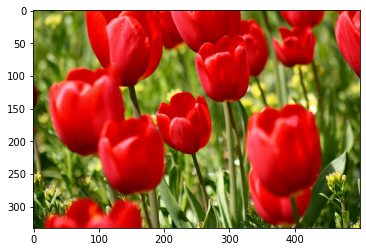

In [4]:
image, label = next(iter(train_ds))
plt.imshow(image)

In [5]:
image = tf.image.resize(image, [180, 180]) / 255  # resizing 하고 scaling
image = tf.expand_dims(image, 0)  # batch size. tf layer에 넣으려면 필수

In [6]:
aug_layer = make_aug_layer()   # augmentation layer 생성

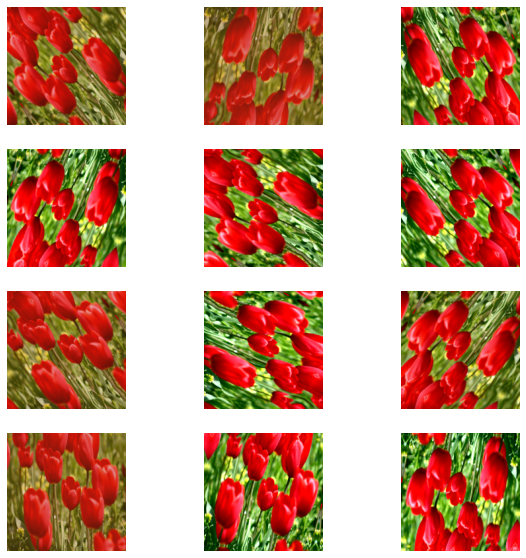

In [7]:
# aug 적용
plt.figure(figsize=(10, 10))
for i in range(12):
  augmented_image = aug_layer(image)
  ax = plt.subplot(4, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


In [17]:
# dataset 만들기
IMG_SIZE = (180, 180)
batch_size = 32

train_ds = train_ds.map(resize_and_scaling).batch(batch_size).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(resize_and_scaling).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(resize_and_scaling).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
next(iter(train_ds))[0].shape

TensorShape([32, 180, 180, 3])

In [10]:
# augentation 적용 x
no_model = tf.keras.Sequential([
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(5)
])

no_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
epochs=10
history = no_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/10
92/92 [==============================] - 9s 53ms/step - loss: 1.3505 - accuracy: 0.4414 - val_loss: 1.0872 - val_accuracy: 0.5804
Epoch 2/10
92/92 [==============================] - 5s 41ms/step - loss: 1.0166 - accuracy: 0.5950 - val_loss: 0.9857 - val_accuracy: 0.5995
Epoch 3/10
92/92 [==============================] - 5s 41ms/step - loss: 0.8373 - accuracy: 0.6795 - val_loss: 0.9482 - val_accuracy: 0.6567
Epoch 4/10
92/92 [==============================] - 5s 41ms/step - loss: 0.6138 - accuracy: 0.7752 - val_loss: 1.2353 - val_accuracy: 0.5886
Epoch 5/10
92/92 [==============================] - 5s 43ms/step - loss: 0.4120 - accuracy: 0.8532 - val_loss: 1.1405 - val_accuracy: 0.6540
Epoch 6/10
92/92 [==============================] - 5s 42ms/step - loss: 0.2487 - accuracy: 0.9135 - val_loss: 1.3305 - val_accuracy: 0.6267
Epoch 7/10
92/92 [==============================] - 5s 41ms/step - loss: 0.1357 - accuracy: 0.9584 - val_loss: 1.4245 - val_accuracy: 0.6512
Epoch 8/10
92

In [13]:
# augmentation
au_model = tf.keras.Sequential([
  aug_layer,
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(5)
])

au_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
history = au_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/10
92/92 [==============================] - 7s 49ms/step - loss: 1.3431 - accuracy: 0.4336 - val_loss: 1.1669 - val_accuracy: 0.5014
Epoch 2/10
92/92 [==============================] - 6s 48ms/step - loss: 1.1174 - accuracy: 0.5443 - val_loss: 0.9987 - val_accuracy: 0.6376
Epoch 3/10
92/92 [==============================] - 6s 47ms/step - loss: 1.0117 - accuracy: 0.6029 - val_loss: 0.8922 - val_accuracy: 0.6567
Epoch 4/10
92/92 [==============================] - 6s 48ms/step - loss: 0.9424 - accuracy: 0.6403 - val_loss: 0.8757 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 6s 47ms/step - loss: 0.8990 - accuracy: 0.6563 - val_loss: 0.9211 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 6s 47ms/step - loss: 0.8761 - accuracy: 0.6560 - val_loss: 0.8304 - val_accuracy: 0.6839
Epoch 7/10
92/92 [==============================] - 6s 48ms/step - loss: 0.7962 - accuracy: 0.6866 - val_loss: 0.7720 - val_accuracy: 0.6894
Epoch 8/10
92

In [18]:
# no aug
loss, acc = no_model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 60ms/step - loss: 1.7001 - accuracy: 0.6866
Accuracy 0.6866484880447388


In [19]:
# aug
loss, acc = au_model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 0s 22ms/step - loss: 0.6930 - accuracy: 0.7411
Accuracy 0.7411444187164307
